# 日本語版CLIPモデルの利用例

- 画像とテキストの類似性計算
- 画像やテキストの埋め込み計算
- テキストや画像による類似画像検索

# 準備

## 依存ライブラリの読み込み

In [1]:
%%capture
!pip install transformers==4.14.0 fugashi ipadic
!pip install japanize-matplotlib

## サンプル画像のダウンロード

In [2]:
!git clone https://github.com/sonoisa/clip-japanese

Cloning into 'clip-japanese'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.


## CLIP用クラス定義

In [3]:
import os
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
from huggingface_hub import hf_hub_download


class ClipTextModel(nn.Module):
    def __init__(self, model_name_or_path, device=None):
        super(ClipTextModel, self).__init__()

        if os.path.exists(model_name_or_path):
            # load from file system
            output_linear_state_dict = torch.load(os.path.join(model_name_or_path, "output_linear.bin"), map_location=device)
        else:
            # download from the Hugging Face model hub
            filename = hf_hub_download(repo_id=model_name_or_path, filename="output_linear.bin")
            output_linear_state_dict = torch.load(filename)

        self.model = AutoModel.from_pretrained(model_name_or_path)
        config = self.model.config

        self.max_cls_depth = 6

        sentence_vector_size = output_linear_state_dict["bias"].shape[0]
        self.sentence_vector_size = sentence_vector_size
        self.output_linear = nn.Linear(self.max_cls_depth * config.hidden_size, sentence_vector_size)
        self.output_linear.load_state_dict(output_linear_state_dict)

        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, 
                                                       is_fast=True, do_lower_case=True)

        self.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
    ):
        output_states = self.model(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            output_attentions=None,
            output_hidden_states=True,
            return_dict=True,
        )
        token_embeddings = output_states[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        hidden_states = output_states["hidden_states"]

        output_vectors = []

        # cls tokens
        for i in range(1, self.max_cls_depth + 1):
            cls_token = hidden_states[-1 * i][:, 0]
            output_vectors.append(cls_token)

        output_vector = torch.cat(output_vectors, dim=1)
        logits = self.output_linear(output_vector)

        output = (logits,) + output_states[2:]
        return output

    @torch.no_grad()
    def encode_text(self, texts, batch_size=8, max_length=64):
        self.eval()
        all_embeddings = []
        iterator = range(0, len(texts), batch_size)
        for batch_idx in iterator:
            batch = texts[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(
                batch, max_length=max_length, padding="longest", 
                truncation=True, return_tensors="pt").to(self.device)
            model_output = self(**encoded_input)
            text_embeddings = model_output[0].cpu()

            all_embeddings.extend(text_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)        

    def save(self, output_dir):
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        torch.save(self.output_linear.state_dict(), os.path.join(output_dir, "output_linear.bin"))


In [4]:
import os
import torch
from torch import nn
import transformers
from huggingface_hub import hf_hub_download


class ClipVisionModel(nn.Module):
    def __init__(self, model_name_or_path, device=None):
        super(ClipVisionModel, self).__init__()

        if os.path.exists(model_name_or_path):
            # load from file system
            visual_projection_state_dict = torch.load(os.path.join(model_name_or_path, "visual_projection.bin"))
        else:
            # download from the Hugging Face model hub
            filename = hf_hub_download(repo_id=model_name_or_path, filename="visual_projection.bin")
            visual_projection_state_dict = torch.load(filename)

        self.model = transformers.CLIPVisionModel.from_pretrained(model_name_or_path)
        config = self.model.config

        self.feature_extractor = transformers.CLIPFeatureExtractor.from_pretrained(model_name_or_path)

        vision_embed_dim = config.hidden_size
        projection_dim = 512

        self.visual_projection = nn.Linear(vision_embed_dim, projection_dim, bias=False)
        self.visual_projection.load_state_dict(visual_projection_state_dict)

        self.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(
        self,
        pixel_values=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_states = self.model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        image_embeds = self.visual_projection(output_states[1])

        return image_embeds

    @torch.no_grad()
    def encode_image(self, images, batch_size=8):
        self.eval()
        all_embeddings = []
        iterator = range(0, len(images), batch_size)
        for batch_idx in iterator:
            batch = images[batch_idx:batch_idx + batch_size]

            encoded_input = self.feature_extractor(batch, return_tensors="pt").to(self.device)
            model_output = self(**encoded_input)
            image_embeddings = model_output.cpu()

            all_embeddings.extend(image_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)        

    @staticmethod
    def remove_alpha_channel(image):
        image.convert("RGBA")
        alpha = image.convert('RGBA').split()[-1]
        background = Image.new("RGBA", image.size, (255, 255, 255))
        background.paste(image, mask=alpha)
        image = background.convert("RGB")
        return image

    def save(self, output_dir):
        self.model.save_pretrained(output_dir)
        self.feature_extractor.save_pretrained(output_dir)
        torch.save(self.visual_projection.state_dict(), os.path.join(output_dir, "visual_projection.bin"))


In [5]:
import os
import torch
from torch import nn
from huggingface_hub import snapshot_download


class ClipModel(nn.Module):
    def __init__(self, model_name_or_path, device=None):
        super(ClipModel, self).__init__()

        if os.path.exists(model_name_or_path):
            # load from file system
            repo_dir = model_name_or_path
        else:
            # download from the Hugging Face model hub
            repo_dir = snapshot_download(model_name_or_path)

        self.text_model = ClipTextModel(repo_dir, device=device)
        self.vision_model = ClipVisionModel(os.path.join(repo_dir, "vision_model"), device=device)

        with torch.no_grad():
            logit_scale = nn.Parameter(torch.ones([]) * 2.6592)
            logit_scale.set_(torch.load(os.path.join(repo_dir, "logit_scale.bin"), map_location=device).clone().cpu())
            self.logit_scale = logit_scale

        self.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, pixel_values, input_ids, attention_mask, token_type_ids):
        image_features = self.vision_model(pixel_values=pixel_values)
        text_features = self.text_model(input_ids=input_ids, 
                                        attention_mask=attention_mask, 
                                        token_type_ids=token_type_ids)[0]

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

    @torch.no_grad()
    def encode(self, images, texts, batch_size=8, max_length=64):
        model.eval()
        image_features = self.vision_model.encode_image(images, batch_size=batch_size)
        text_features = self.text_model.encode_text(texts, batch_size=batch_size, max_length=max_length)

        image_features = image_features.to(self.device)
        text_features = text_features.to(self.device)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        logits_per_image = logits_per_image.cpu()
        logits_per_text = logits_per_text.cpu()

        return logits_per_image, logits_per_text

    def save(self, output_dir):
        torch.save(self.logit_scale, os.path.join(output_dir, "logit_scale.bin"))
        self.text_model.save(output_dir)
        self.vision_model.save(os.path.join(output_dir, "vision_model"))


## テキストの正規化処理定義

In [6]:
# https://github.com/neologd/mecab-ipadic-neologd/wiki/Regexp.ja から引用・一部改変
from __future__ import unicode_literals
import re
import unicodedata

def unicode_normalize(cls, s):
    pt = re.compile('([{}]+)'.format(cls))

    def norm(c):
        return unicodedata.normalize('NFKC', c) if pt.match(c) else c

    s = ''.join(norm(x) for x in re.split(pt, s))
    s = re.sub('－', '-', s)
    return s

def remove_extra_spaces(s):
    s = re.sub('[ 　]+', ' ', s)
    blocks = ''.join(('\u4E00-\u9FFF',  # CJK UNIFIED IDEOGRAPHS
                      '\u3040-\u309F',  # HIRAGANA
                      '\u30A0-\u30FF',  # KATAKANA
                      '\u3000-\u303F',  # CJK SYMBOLS AND PUNCTUATION
                      '\uFF00-\uFFEF'   # HALFWIDTH AND FULLWIDTH FORMS
                      ))
    basic_latin = '\u0000-\u007F'

    def remove_space_between(cls1, cls2, s):
        p = re.compile('([{}]) ([{}])'.format(cls1, cls2))
        while p.search(s):
            s = p.sub(r'\1\2', s)
        return s

    s = remove_space_between(blocks, blocks, s)
    s = remove_space_between(blocks, basic_latin, s)
    s = remove_space_between(basic_latin, blocks, s)
    return s

def normalize_neologd(s):
    s = s.strip()
    s = unicode_normalize('０-９Ａ-Ｚａ-ｚ｡-ﾟ', s)

    def maketrans(f, t):
        return {ord(x): ord(y) for x, y in zip(f, t)}

    s = re.sub('[˗֊‐‑‒–⁃⁻₋−]+', '-', s)  # normalize hyphens
    s = re.sub('[﹣－ｰ—―─━ー]+', 'ー', s)  # normalize choonpus
    s = re.sub('[~∼∾〜〰～]+', '〜', s)  # normalize tildes (modified by Isao Sonobe)
    s = s.translate(
        maketrans('!"#$%&\'()*+,-./:;<=>?@[¥]^_`{|}~｡､･｢｣',
              '！”＃＄％＆’（）＊＋，－．／：；＜＝＞？＠［￥］＾＿｀｛｜｝〜。、・「」'))

    s = remove_extra_spaces(s)
    s = unicode_normalize('！”＃＄％＆’（）＊＋，－．／：；＜＞？＠［￥］＾＿｀｛｜｝〜', s)  # keep ＝,・,「,」
    s = re.sub('[’]', '\'', s)
    s = re.sub('[”]', '"', s)
    s = s.lower()
    return s

def normalize_text(text):
    return normalize_neologd(text)

## 学習済み日本語CLIPモデルのダウンロード

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ClipModel("sonoisa/clip-vit-b-32-japanese-v1", device=device)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/685 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.44M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/713 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

# 1. 画像とテキストの類似性計算

16枚の画像について、文章との類似度を求めます。

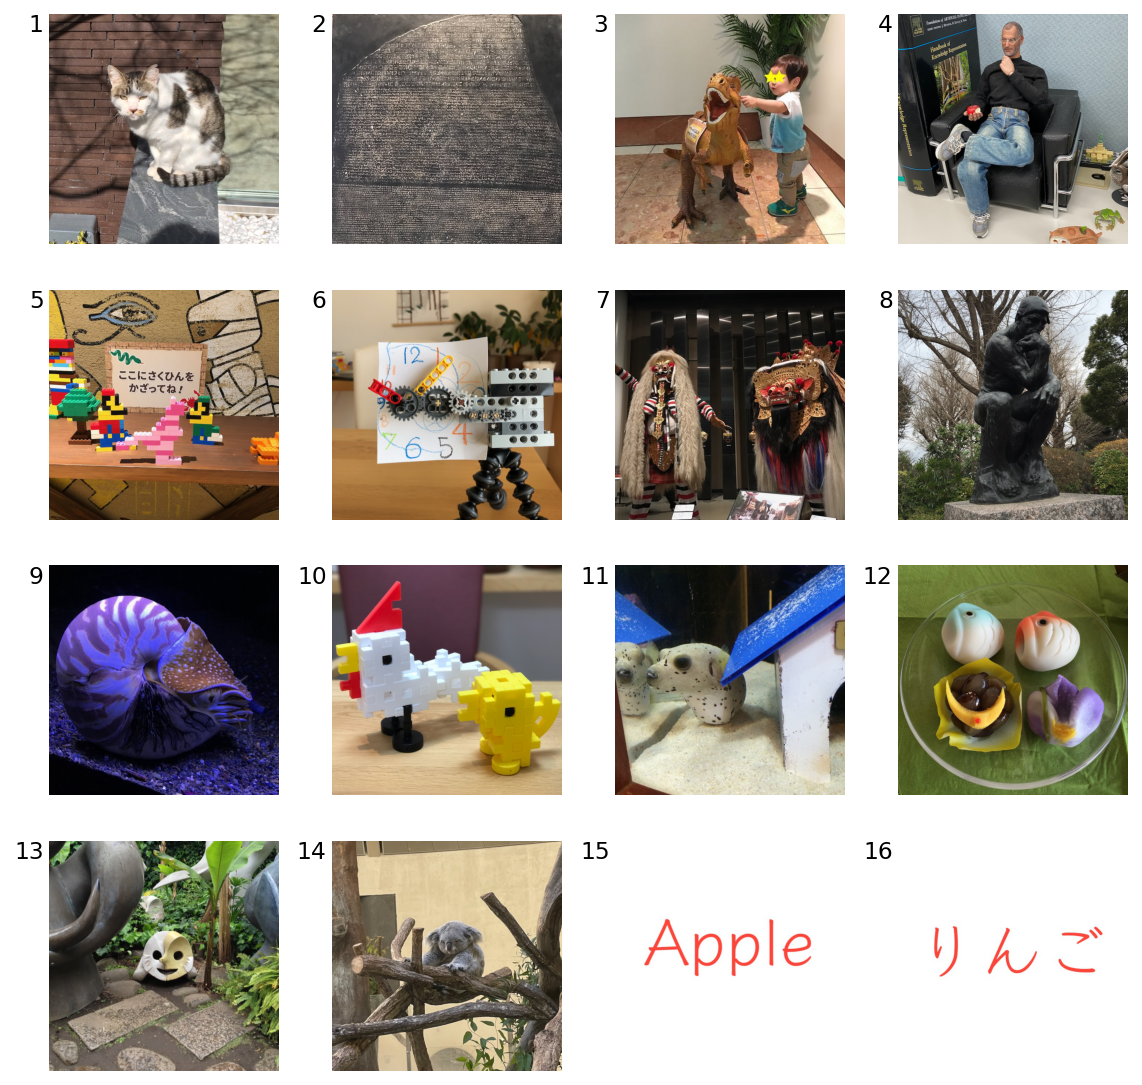

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

# 類似度を求める対象の画像（16枚）
images = [Image.open(f"/content/clip-japanese/sample_images/{i}.jpeg") for i in range(1, 17)]

# タイリング表示
plt.figure(dpi=140, figsize=(10,10))

for i in range(len(images)):
    sp = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    text = sp.text(-16, 0, f"{i + 1}", ha="right", va="top", color="black", fontsize=12)
    plt.axis("off")

類似度を計算します。

- logits_per_imageのsoftmaxをとると、1つの画像に関する各文章の類似度（合計1.0）になります。
- logits_per_textのsoftmaxをとると、1つの文章に関する各画像の類似度（合計1.0）になります。



In [9]:
import torch

# 画像との類似度を求める文章
texts = ["猫",
         "ロゼッタストーン",
         "恐竜と子供", "恐竜", "子供",  # 複数の物体が写っているとき、全体を見て類似性を判定するか？
         "考えるスティーブ・ジョブズの人形",  # 考える人との混同が起きないか？
         "レゴでできたマリオやルイージなど",  # レゴやマリオといった固有名詞を認識できるか？
         "レゴでできた時計",  # 時計に見えるかギリギリのものを認識できるか？
         "魔女ランダと聖獣バロン", "特殊合体するとシヴァ神",  # あまりメジャーではなさそうな存在を認識できるか？
         "彫刻「考える人」",  # 考えるスティーブ・ジョブズとの混同が起きないか？
         "水槽の中のアンモナイト",  # コクテンフグと見分けがつくか？
         "鶏とヒヨコのおもちゃ",  # 抽象的な造形表現を認識できるか？
         "水槽の中の犬", "水槽の中のコクテンフグ",  # 犬と錯覚するか？
         "お菓子が1個", "お菓子が2個", "お菓子が3個", "お菓子が4個", "お菓子が5個",  # 数勘定できるか？
         "彫刻「午後の日」", "芸術作品",  # 日本の芸術作品を認識できるか？
         "眠るコアラ", "木登りするコアラ",  # 行動を識別できるか？
         "Apple", "Pineapple",  # アルファベットを認識できるか？（英語版CLIPではできるため、できなくなっていないかの確認）
         "りんご", "パイナップル",  # ひらがなを認識できるか？
        ]

texts = [normalize_text(text) for text in texts]  # この正規化は必須です。行わないと精度が落ちることがあります。

logits_per_image, logits_per_text = model.encode(images, texts)

similarity_per_image = torch.softmax(logits_per_image, dim=1)

画像と文章との類似度を可視化します。  
画像（縦軸）ごとに、その画像と各文章の類似度（横軸）を示します。  
赤丸は正解です。

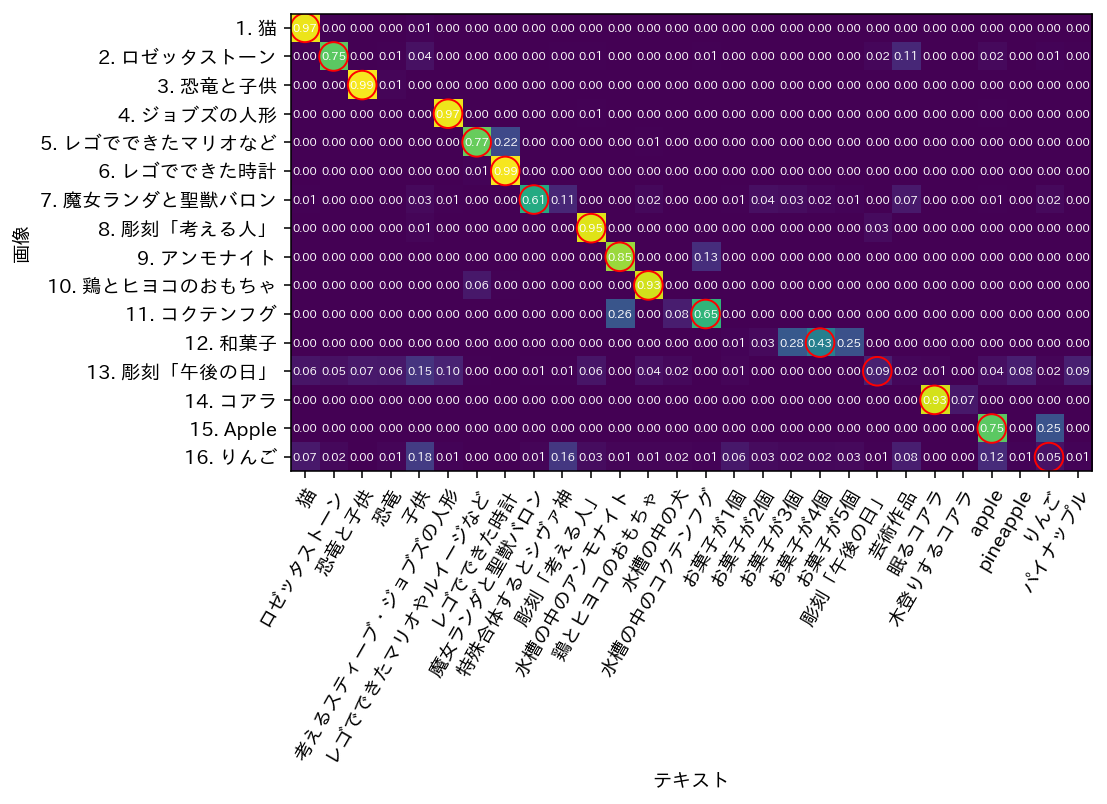

In [10]:
# ref. https://stackoverflow.com/questions/8897593/how-to-compute-the-similarity-between-two-text-documents
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib
import numpy as np

def heatmap(x_labels, y_labels, expected_answers, values):
    fig, ax = plt.subplots(dpi=140, figsize=(8, 8))
    im = ax.imshow(values, vmin=0, vmax=1, cmap="viridis")

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("テキスト")
    ax.set_ylabel("画像")

    plt.setp(ax.get_xticklabels(), rotation=60, ha="right", fontsize=10,
            rotation_mode="anchor")

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            ax.text(j, i, "%.2f" % values[i, j], 
                    ha="center", va="center", color="w", fontsize=6)
            if expected_answers[i] == j:
                c = patches.Circle(xy=(j, i), radius=0.5, ec='r', fill=False)
                ax.add_patch(c)

    fig.tight_layout()
    plt.show()

x_labels = texts
y_labels = ["1. 猫", "2. ロゼッタストーン", "3. 恐竜と子供", "4. ジョブズの人形", 
            "5. レゴでできたマリオなど", "6. レゴでできた時計", "7. 魔女ランダと聖獣バロン", 
            "8. 彫刻「考える人」", "9. アンモナイト", "10. 鶏とヒヨコのおもちゃ", "11. コクテンフグ", 
            "12. 和菓子", "13. 彫刻「午後の日」", "14. コアラ", "15. Apple", 
            "16. りんご"]
expected_answers = [0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 14, 18, 20, 22, 24, 26]
heatmap(x_labels, y_labels, expected_answers, similarity_per_image)

# 2. 画像とテキストの埋め込み計算

画像とテキストの埋め込みベクトルを得る方法について説明します。

画像の埋め込みベクトルを計算します。  
model.vision_modelのencode_image(images)を呼び出すだけです。  
この例では 3 x 512 次元のテンソルが得られます。

In [11]:
sample_images_3 = [Image.open(f"/content/clip-japanese/sample_images/{i}.jpeg") for i in range(1, 4)]
image_features = model.vision_model.encode_image(sample_images_3)

同様に、テキストの埋め込みベクトルを計算します。  
model.text_modelのencode_text(texts)を呼び出すだけです。

In [12]:
sample_texts_3 = ["猫", "ロゼッタストーン", "恐竜と子供"]
sample_texts_3 = [normalize_text(text) for text in sample_texts_3]  # この正規化は必須です。行わないと精度が落ちることがあります。
text_features = model.text_model.encode_text(sample_texts_3)

この画像とテキストの埋め込みベクトルのコサイン類似度を求めてみます。  
行と列両方について対角要素が最も大きな値になることが期待されます。

In [13]:
# 単位ベクトル化
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

similarity_matrix = image_features @ text_features.t()
print(similarity_matrix)

tensor([[0.2791, 0.2241, 0.1885],
        [0.1993, 0.2562, 0.1899],
        [0.1845, 0.1842, 0.3355]])


# 3. 類似画像検索

テキストや画像を用いた画像検索をしてみます。

In [14]:
# 検索対象となる画像の埋め込みベクトルを計算しておく。
target_images = [Image.open(f"/content/clip-japanese/sample_images/{i}.jpeg") for i in range(1, 17)]
target_vectors = model.vision_model.encode_image(target_images).numpy()

In [15]:
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import math


def search_image(query_vector, target_vectors, target_images, closest_n=3):
    distances = scipy.spatial.distance.cdist(
        query_vector, target_vectors, metric="cosine"
    )[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    # タイリング表示
    plt.figure(dpi=140, figsize=(6,6))

    for i, (idx, distance) in enumerate(results[0:closest_n]):
        image = target_images[idx]

        sp = plt.subplot(math.ceil(closest_n / 4), 4, i + 1)
        plt.imshow(image)
        text = sp.text(-32, 0, f"{i + 1}: {distance:0.5f}", ha="left", va="bottom", color="black", fontsize=12)
        plt.axis("off")    

def search_image_by_text(text, target_vectors, target_images, closest_n=3):
    text = normalize_text(text)
    text_features = model.text_model.encode_text([text]).numpy()
    search_image(text_features, target_vectors, target_images, closest_n)

def search_image_by_image(image, target_vectors, target_images, closest_n=3):
    image_features = model.vision_model.encode_image([image]).numpy()
    search_image(image_features, target_vectors, target_images, closest_n)


テキストで画像を検索してみます。

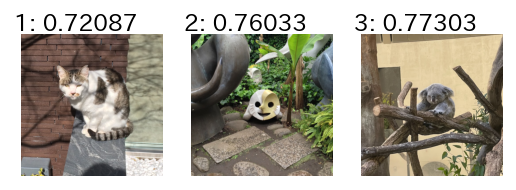

In [16]:
text = "猫"
search_image_by_text(text, target_vectors, target_images, closest_n=3)

与えられた画像に似た画像を探します。

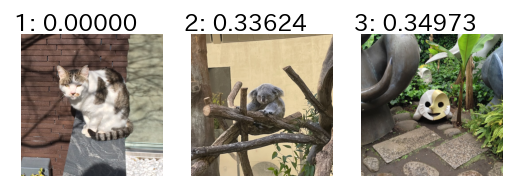

In [17]:
image = Image.open(f"/content/clip-japanese/sample_images/1.jpeg")
search_image_by_image(image, target_vectors, target_images, closest_n=3)